In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# # Seaborn imports (stylistic for nice plots)
# import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
#     'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
# sns.set(style='ticks', rc=rc)

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

In [3]:
import atp_cal

In [4]:
atp_cal.pboc_style_mpl()

# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

## Import Images

In [5]:
#This should not change between experiments:
datapath = '../../data/atp_cal'

#This varies between experiments. 
datafolder = '2023-11-21_A81D_Cal' #EDIT THIS EVERY TIME

# bound Images
included_bound = '*uM*/*Pos*/*405*.tif' #EDIT THIS EVERY TIME
bound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_bound))

# unbound Images
included_unbound = '*uM*/*Pos*/*480*.tif' #EDIT THIS EVERY TIME
unbound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_unbound))

ATPconc=[]
for i, file in enumerate(unbound_files):
    conc = int(file.split('/')[5].split('_')[1].split('uM')[0]) #EDIT THIS EVERY TIME
    ATPconc.append(conc)
ATPconc = np.array(ATPconc)

#Read in images and save as array:
bound_array = atp_cal.file_to_image(bound_files)
unbound_array = atp_cal.file_to_image(unbound_files)

# Set background - want a no ATeam image for this
bound_bg = 1915
unbound_bg = 1915


# Define the zero concentration image (DO EVERY TIME):
bound_zero = np.average(bound_array[np.where(ATPconc==0)], axis=0)
unbound_zero = np.average(unbound_array[np.where(ATPconc==0)], axis=0)

## Subtract background

In [6]:
#Subtract im_dark from all calibration images
bound_bs = bound_array - bound_bg
unbound_bs = unbound_array - unbound_bg

In [7]:
unbound_bs[unbound_bs<0] = 0
bound_bs[unbound_bs<0] = 0

## Correct for uneven illumination background subtraction

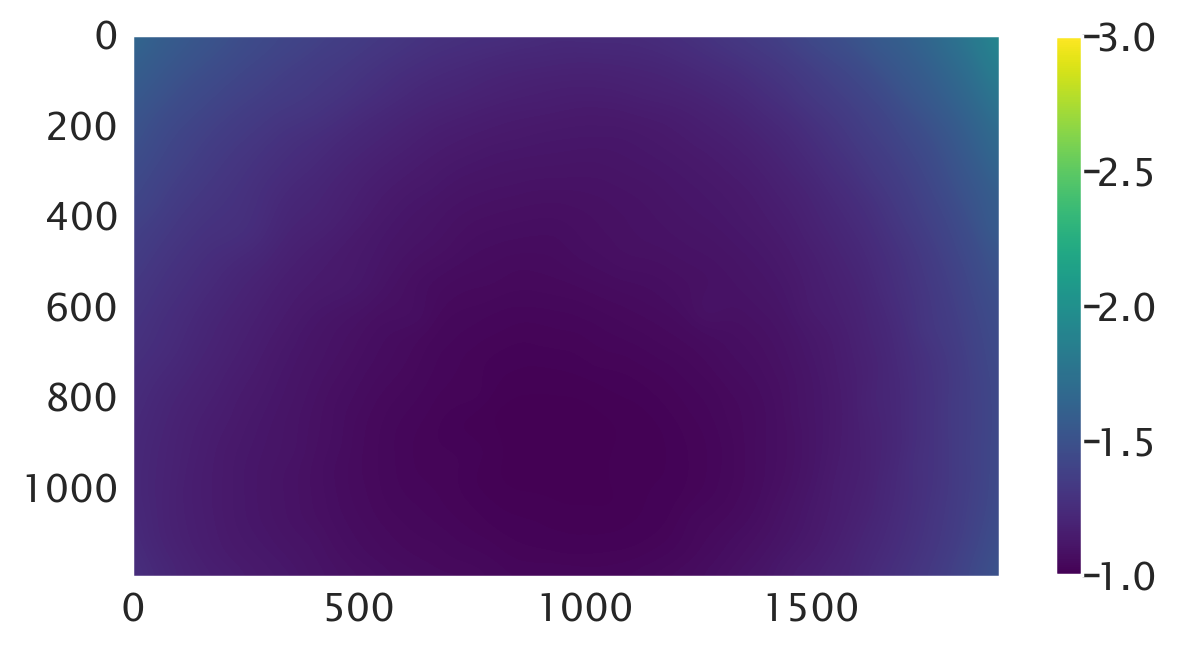

In [8]:
#Find the normilization matrix
bound_norm_mat = atp_cal.norm_mat_fn_iATP(bound_zero, bound_bg)
unbound_norm_mat = atp_cal.norm_mat_fn_iATP(unbound_zero, unbound_bg)

#plot the normalizaiton matrix
plt.imshow(unbound_norm_mat, vmin = 1, vmax = 3)
plt.colorbar(shrink = 0.7)
plt.grid(False)

In [9]:
#Normalize all the claibration images by multiplying by the normalization matrix
bound_norm = bound_bs*bound_norm_mat
unbound_norm = unbound_bs*unbound_norm_mat

## Calculate the average intensity value per concentration

In [10]:
#Average over the non-zero values in the image to get the calibration
bound_calavg = np.average(bound_norm, axis=(1,2))
unbound_calavg = np.average(unbound_norm, axis=(1,2))
ratio_calavg = bound_calavg/unbound_calavg 

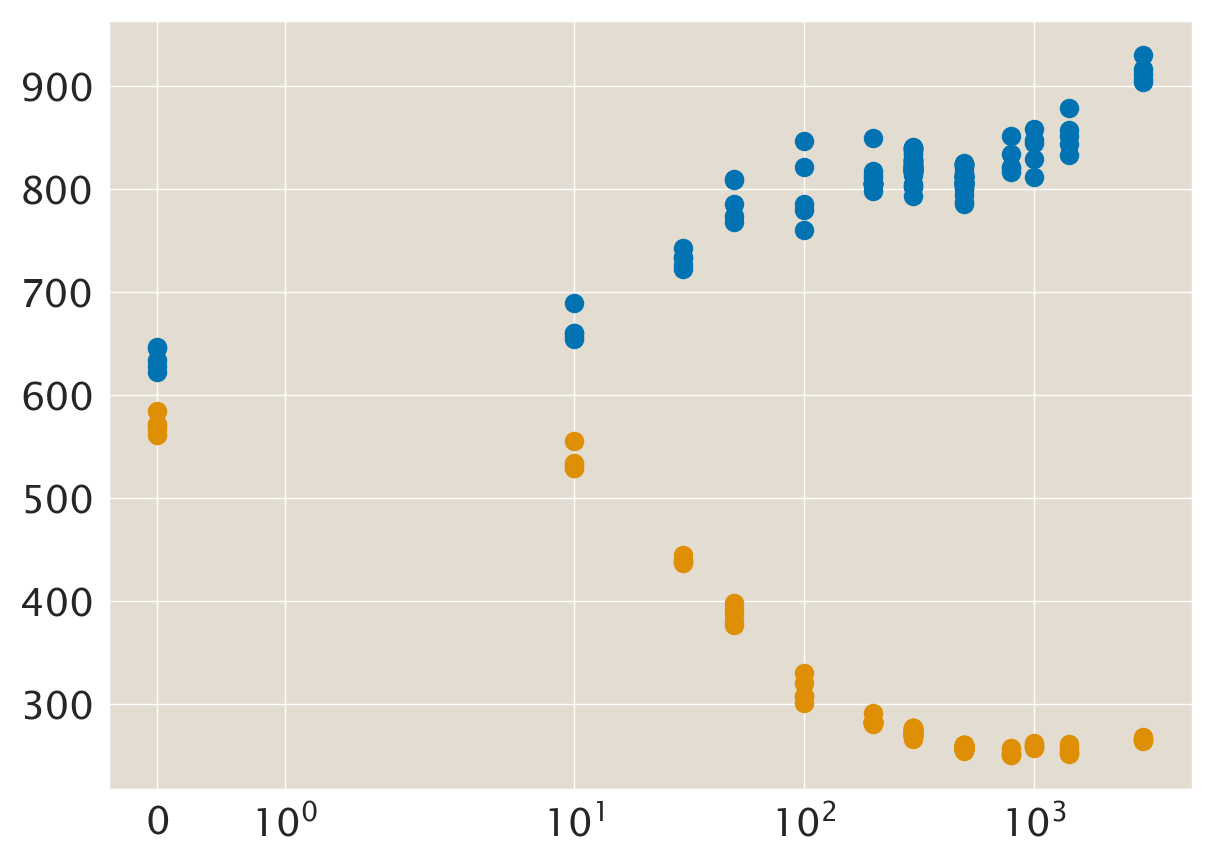

In [30]:
plt.scatter(ATPconc, bound_calavg)
plt.scatter(ATPconc, unbound_calavg)
plt.xscale('symlog')
plt.tick_params(which='minor', length=100, color='k')

## Plot the data and fit to a Hill function

In [11]:
#Langmuir equation
def ATeam_Hill(conc, a, b, c, d):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """
    
    
    
    return (((b-c)*(conc/a)**d/(1+(conc/a)**d))+c)



#Curve-fit to the Langmuir curve
def ATeam_Hill_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 4 entries of parameter guesses for a, b, c, and d in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(ATeam_Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(4), np.ones([4])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = ATeam_Hill(xvals, param[0], param[1], param[2], param[3])
    
    return param, curve, xvals

[67.60201128  3.36417414  1.06783864  1.17289855]


Text(0.5, 1.0, 'Km = 68 µM n = 1.2')

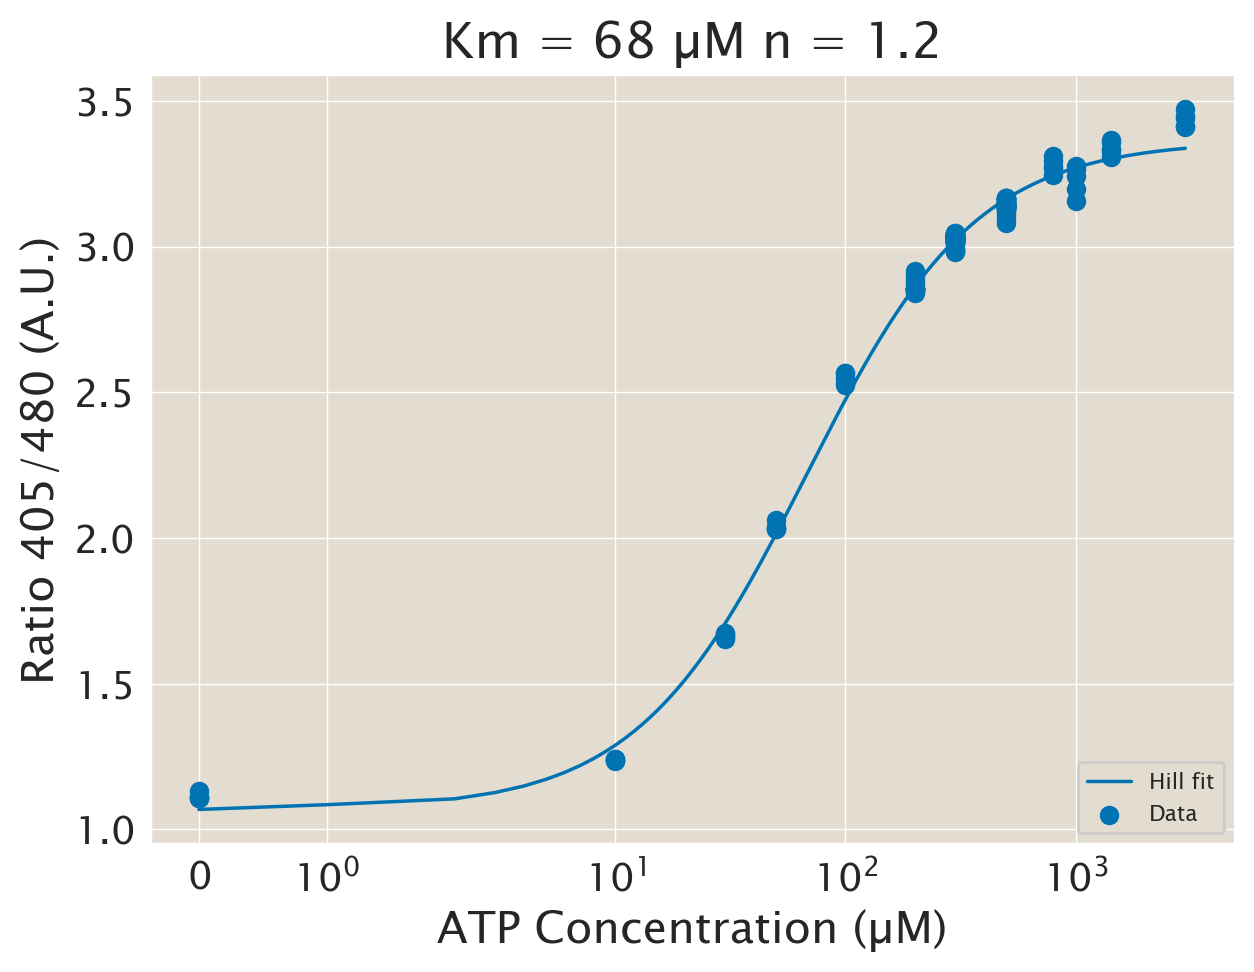

In [12]:
params, curve, xvals = ATeam_Hill_curve_fit(ATPconc, ratio_calavg, np.max(ATPconc), [300, 1, 0.5, 2])
print(params)

plt.scatter(ATPconc, ratio_calavg, label = 'Data')
plt.xscale('symlog')
plt.plot(xvals, curve, label='Hill fit')
plt.legend(loc = 'lower right')
plt.xlabel('ATP Concentration (µM)')
plt.ylabel('Ratio 405/480 (A.U.)')
plt.title('Km = ' +str(round(params[0])) + ' µM'+ ' n = ' + str(round(params[3], 1)))

In [13]:
df_fit = pd.DataFrame({'Param' : ['Km', 'Rmax', 'Rmin', 'n'], 'Value' : params})
df_fit.to_csv('../../analyzed_data/atp_cal/' + datafolder + '/df_fit')

df_data = pd.DataFrame({'ATP uM' : ATPconc, 'Ratio' : ratio_calavg})
df_data.to_csv('../../analyzed_data/atp_cal/' + datafolder + '/df_data')